In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

1. Loading and Cleaning data


In [ ]:
#Loading and cleaning data
df = pd.read_csv("C:/Users/oshah/Downloads/Battery Health Prediction/EvBatteryCharging.csv")
df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('(', '').str.replace(')', '')
df.replace(["?", "NA", "null", "-", "--"], np.nan, inplace=True)
df.dropna(subset=['TR_Probability'], inplace=True)

In [10]:
df.sample(6)

,Timestamp,ChargerID,CellID,ChargingStage,PackVoltage_V,CellVoltage_V,DemandVoltage_V,ChargeCurrent_A,DemandCurrent_A,SOC_%,...,StateOfHealth_%,VibrationLevel_mg,MoistureDetected,BMS_Status,ChargePower_kW,Pressure_kPa,TR_Probability,EventFlag,Notes,RiskLabel
163,9/3/2025 10:43,CH4,CELL43,Parameter_Config,346.79,3.992,341.91,30.04,34.91,92.75,...,92.96,36.80,False,Critical,10.42,91.31,1.000,Runaway,Critical thermal runaway risk; Rapid temp rise,1
54,9/3/2025 8:54,CH5,CELL8,Handshake,356.37,3.750,353.92,107.30,110.19,42.59,...,83.48,20.65,False,OK,38.24,99.45,1.000,Runaway,Critical thermal runaway risk; Rapid temp rise,1
262,9/3/2025 12:22,CH4,CELL48,Parameter_Config,350.79,3.663,352.69,82.32,83.14,76.46,...,98.00,44.32,True,OK,28.88,117.90,0.849,Alarm,High internal resistance; Moisture detected,1
1,9/3/2025 8:01,CH7,CELL7,End_Of_Charge,336.91,4.101,332.69,75.11,72.66,83.07,...,90.72,43.07,True,Warning,25.31,98.74,0.997,Runaway,Critical thermal runaway risk; Moisture detected,1
131,9/3/2025 10:11,CH4,CELL24,Handshake,338.04,3.689,336.85,110.50,106.12,72.73,...,84.78,25.49,True,Warning,37.35,115.89,0.964,Runaway,Critical thermal runaway risk; Moisture detected,1
348,9/3/2025 13:48,CH8,CELL25,Parameter_Config,380.13,3.915,376.89,90.32,92.81,30.89,...,82.62,3.91,False,Warning,34.33,104.88,0.488,Warning,Normal operation,0


In [13]:
print(df.info())
print(df.shape)
print(df.columns)
print(df.index)
print(df.describe())
print(df.value_counts())
print(df.isnull().sum())
print(df.notnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                500 non-null    object 
 1   ChargerID                500 non-null    object 
 2   CellID                   500 non-null    object 
 3   ChargingStage            500 non-null    object 
 4   PackVoltage_V            500 non-null    float64
 5   CellVoltage_V            500 non-null    float64
 6   DemandVoltage_V          500 non-null    float64
 7   ChargeCurrent_A          500 non-null    float64
 8   DemandCurrent_A          500 non-null    float64
 9   SOC_%                    500 non-null    float64
 10  MaxTemp_C                500 non-null    float64
 11  MinTemp_C                500 non-null    float64
 12  AvgTemp_C                500 non-null    float64
 13  AmbientTemp_C            500 non-null    float64
 14  InternalResistance_mOhm  5

In [ ]:
#Creating binary target for classification: High Risk = TR_Probability > 0.5
df['RiskLabel'] = (df['TR_Probability'] > 0.5).astype(int)

#Filling missing values if any(not needed)...
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\oshah\AppData\Local\Temp\ipykernel_36668\2653152921.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\oshah\AppData\Local\Temp\ipykernel_36668\2653152921.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

 2. Features Selection

In [ ]:
#Features selection
features = ['PackVoltage_V', 'CellVoltage_V', 'ChargeCurrent_A', 'AvgTemp_C', 'MaxTemp_C', 'InternalResistance_mOhm', 'Pressure_kPa', 'SOC_%']
X = df[features]

In [ ]:
#Encoding categorical if any (none here, but for safety...)
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [14]:
df.shape

(500, 25)

Gradient Boosting Classifier Algorithm


In [ ]:
#Classification Task
y_class = df['RiskLabel']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, stratify=y_class, test_size=0.2, random_state=42)

clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
clf.fit(X_train_c, y_train_c)
y_pred = clf.predict(X_test_c)
y_pred_prob = clf.predict_proba(X_test_c)[:, 1]

print("Classification Results:")
print("Accuracy:", accuracy_score(y_test_c, y_pred))
print("ROC AUC:", roc_auc_score(y_test_c, y_pred_prob))
print(classification_report(y_test_c, y_pred))


Classification Results:
Accuracy: 0.92
ROC AUC: 0.9622063329928499
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.95      0.97      0.96        89

    accuracy                           0.92       100
   macro avg       0.81      0.76      0.78       100
weighted avg       0.91      0.92      0.92       100



Gradient Boosting Regressor Algorithm

In [7]:
# Regression Task
y_reg = df['TR_Probability']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
reg.fit(X_train_r, y_train_r)
y_pred_reg = reg.predict(X_test_r)

rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_reg))
r2 = r2_score(y_test_r, y_pred_reg)

print("\nRegression Results:")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Regression Results:
RMSE: 0.0240
R^2 Score: 0.9826


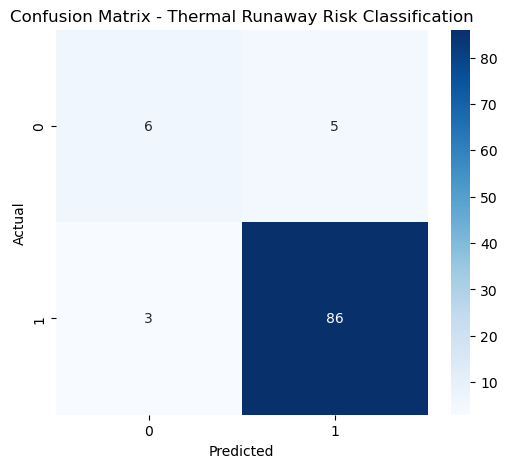

In [ ]:
#Confusion Matrix Plot
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_c, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Thermal Runaway Risk Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [9]:
import pickle

# Save classifier
with open('btms_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

# Save regressor
with open('btms_regressor.pkl', 'wb') as f:
    pickle.dump(reg, f)
